In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# source files
import sys
sys.path.append('../')

from scripts.calibrated_regression import CalibratedRegression
from scripts.data_loader import load_quadratic_data

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

---

# Experiments

## Experiment 1: Polynomial Regression Model
### Misspecified Noise in the Model

$$
\begin{aligned}
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\hat{y} &\sim \mathcal{N}(ax^2 + bx + c, \sigma=1) \\
\end{aligned}
$$

Note that $\sigma=1$ but the true $\sigma$ of the data is 2. This is an example of model misspecification and cannot be avoided as we don't know what the true $\sigma$ of the data is.

### Creating Data For Experiments 1 and 2

(1250,) (250,) (1250,) (250,)


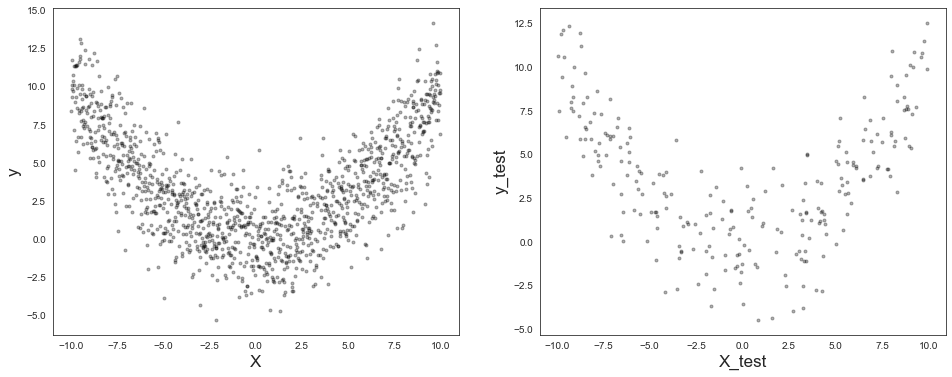

In [2]:
X, X_test, y, y_test = load_quadratic_data()
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

### Modeling

In [3]:
with pm.Model() as model_misspecified:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1301.43draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.098812,0.000928,0.000025,0.097025,0.100673,1362.277657,0.999583
b,-0.017894,0.005019,0.000134,-0.027654,-0.008291,1632.406141,1.000805
c,0.078299,0.040839,0.001079,0.002986,0.165416,1229.003159,0.999569


In [4]:
def posterior_predictive(x, a, b, c, sigma=1):
    '''Returns samples from posterior predictive.
    
    Parameters
    ----------
    x : array-like
        Data
    a : np.array
        Posterior samples of a
    b : np.array
        Posterior samples of b
    c : np.array
        Posterior samples of c
    sigma : float
        Standard deviation of observation noise
            
    Returns
    -------
    samples : np.array
    '''
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

In [5]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model_misspecified, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,1.674450,-0.452298,0.228,0.352
1,2.568379,-0.248625,0.185,0.312
2,6.731154,4.880090,0.678,0.524
3,8.732488,10.379446,1.000,1.000
4,5.543696,3.619601,0.728,0.572


[1.25000000e-04 5.99000000e-01 9.98958333e-01]


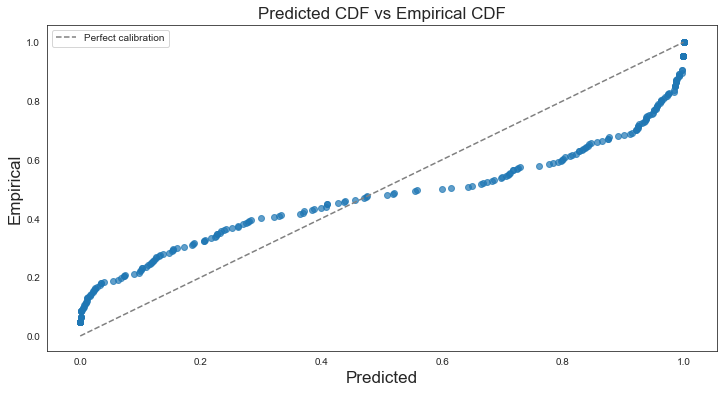

In [6]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

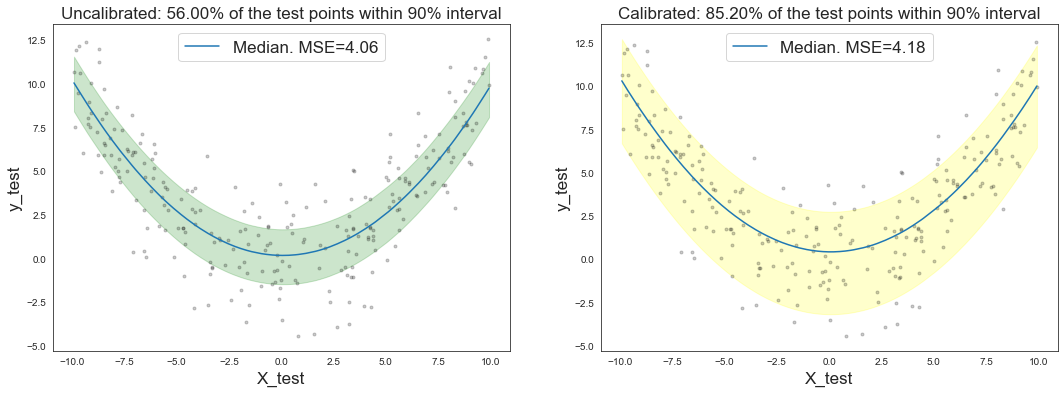

In [7]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

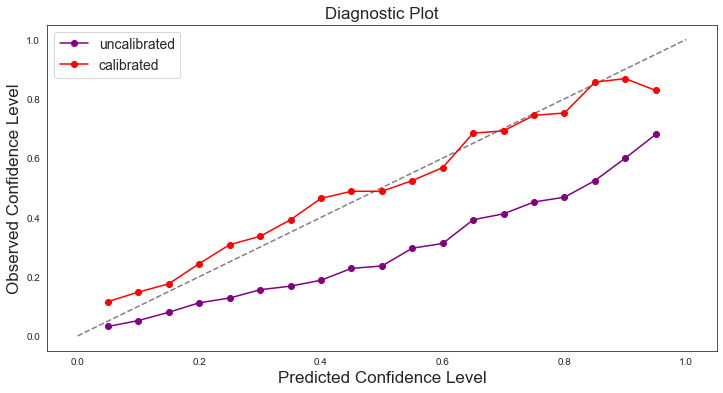

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

## Experiment 2: Polynomial Regression Model
### Misspecified Noise in the Model

Priors:

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=2
$$

Note that $\sigma=2$ here, which is how the data was generated

In [9]:
with pm.Model() as model_correct:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=2, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1483.76draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.098807,0.001888,0.000054,0.094786,0.102322,1240.474435,0.999547
b,-0.018234,0.009595,0.000259,-0.037139,-0.000319,1424.402203,1.000042
c,0.079993,0.084515,0.002282,-0.082893,0.240448,1249.491517,0.999813


In [10]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c, 'sigma':2}
calib = CalibratedRegression(X, y, model_misspecified, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,-0.380254,-0.499385,0.376,0.368
1,2.915277,-0.983048,0.185,0.188
2,-5.383589,2.913884,0.465,0.484
3,-6.624416,7.521200,0.925,0.928
4,-9.426284,10.085812,0.689,0.728


[0.0425 0.497  0.949 ]


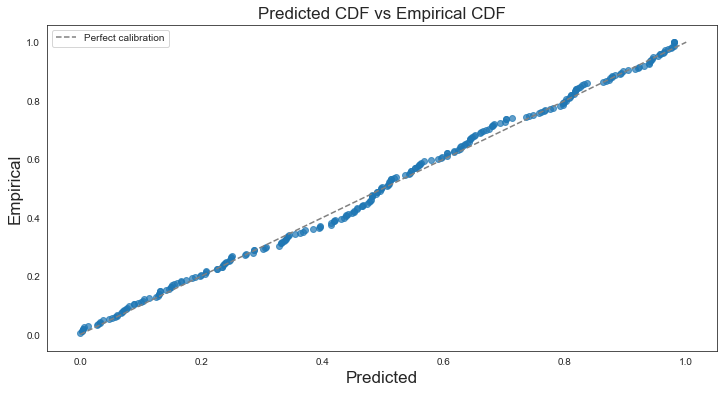

In [11]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

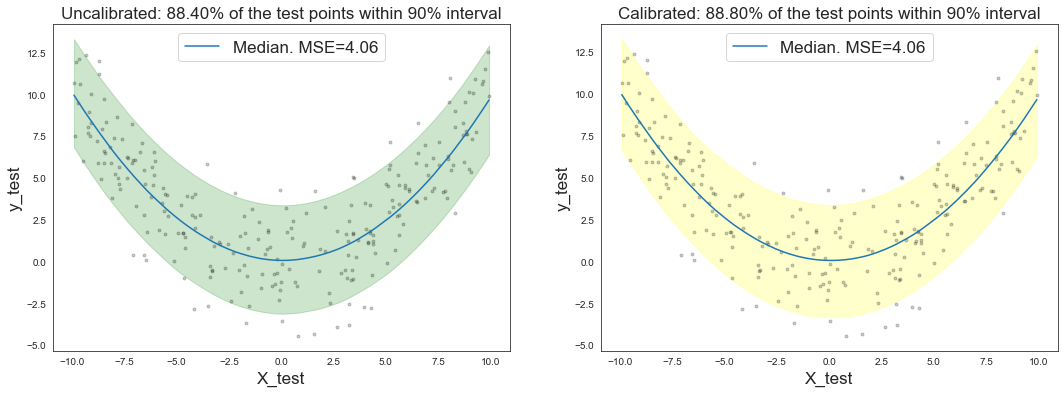

In [12]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

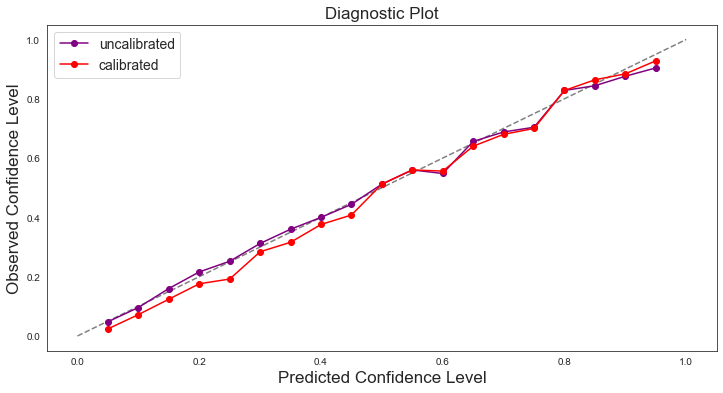

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

## Experiment 3: Polynomial Regression Model
### Dataset Shift: training data and test data are different

Priors:

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=1
$$

Note that $\sigma=1$ here, which is how the data was generated

### Creating Data For Experiment 3

(1250,) (250,) (1250,) (250,)


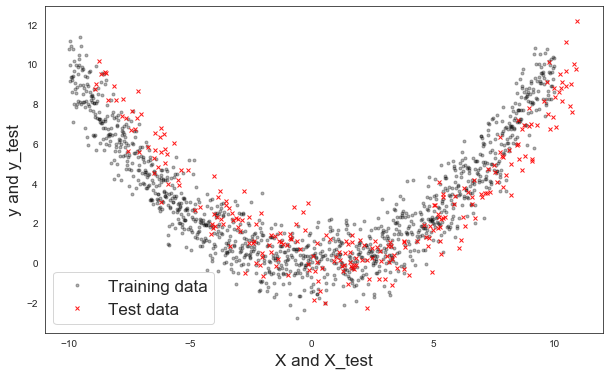

In [14]:
X, X_test, y, y_test = load_quadratic_data(scale=1)
dif = 1
X_test += dif
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.set_xlabel('X and X_test', fontsize=17)
ax.set_ylabel('y and y_test', fontsize=17)

ax.plot(X, y, 'o', markersize=3, color='black', alpha=0.3, label='Training data')
ax.plot(X_test, y_test, 'x', markersize=4, color='red', alpha=0.9, label='Test data')
ax.legend(fontsize=17)
ax.set_xlim(-11, 11+dif);

### Modeling

In [15]:
with pm.Model() as model_correct:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1260.92draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.099193,0.000968,0.000025,0.097320,0.101015,1435.477721,0.999523
b,0.002693,0.004906,0.000120,-0.007086,0.012337,1526.627907,0.999540
c,-0.014695,0.043083,0.001087,-0.102156,0.063621,1447.743480,0.999529


In [16]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c, 'sigma':1}
calib = CalibratedRegression(X, y, model_misspecified, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,-4.596398,2.202512,0.550,0.556
1,1.247498,0.985338,0.795,0.804
2,0.100067,0.401887,0.645,0.648
3,1.127418,1.101355,0.839,0.844
4,-1.100734,0.109822,0.509,0.512


[0.059  0.478  0.9345]


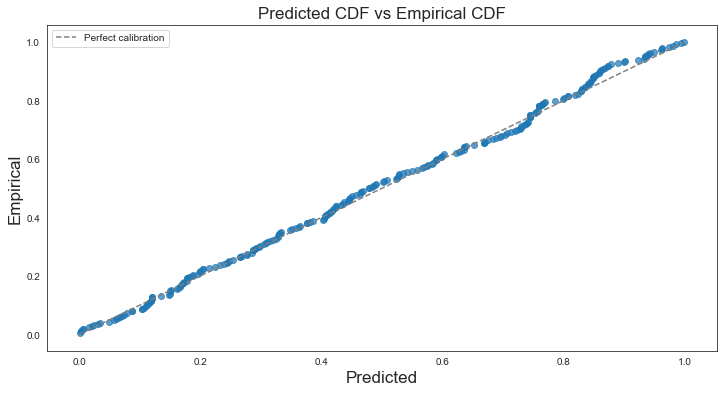

In [17]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

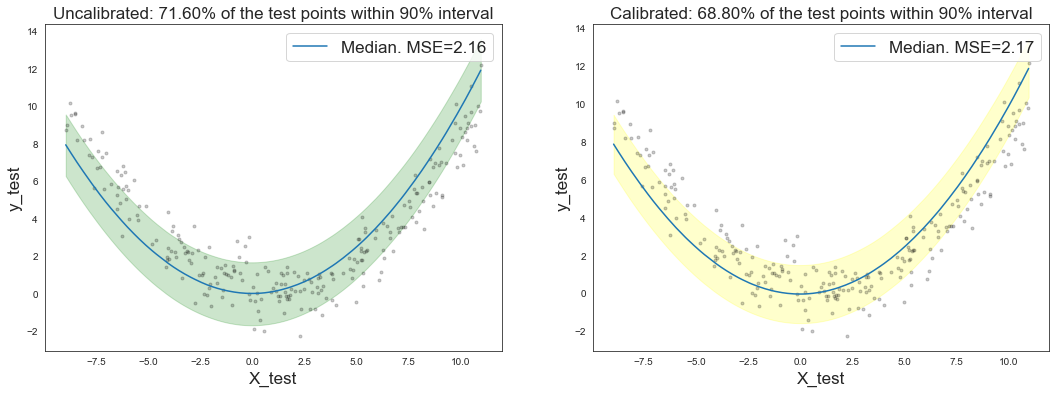

In [18]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

---